In [8]:
import json
import os
import pickle
import sys

import ee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm


from shapely.geometry import box
from geojson import Point, Feature, FeatureCollection, dump
import geopandas

sys.path.append('../')
from scripts.get_s2_data_ee import get_history, get_history_polygon, get_pixel_vectors

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [632]:
keras.models.load_model('../models/1-20-2021-filtered-both.h5').input_shape

(None, 12, 1)

In [9]:
# Sentinel 2 band descriptions
band_descriptions = {
    'B1': 'Aerosols, 442nm',
    'B2': 'Blue, 492nm',
    'B3': 'Green, 559nm',
    'B4': 'Red, 665nm',
    'B5': 'Red Edge 1, 704nm',
    'B6': 'Red Edge 2, 739nm',
    'B7': 'Red Edge 3, 779nm',
    'B8': 'NIR, 833nm',
    'B8A': 'Red Edge 4, 864nm',
    'B9': 'Water Vapor, 943nm',
    'B11': 'SWIR 1, 1610nm',
    'B12': 'SWIR 2, 2186nm'
}

## Load Sampling Locations

In [12]:
data_dir = os.path.join('..', 'data')

with open(os.path.join(data_dir, 'MinesPos2018-2020Sentinel.geojson'), 'r') as f:
    positive_sites = json.load(f)['features']
    
with open(os.path.join(data_dir, 'MinesNeg2018-2020Sentinel.geojson'), 'r') as f:
    negative_sites = json.load(f)['features']

In [13]:
mining_sites = pd.DataFrame({
    'name': ['positive_' + str(i) for i in range(len(positive_sites))],
    'lon': [np.squeeze(site['geometry']['coordinates'])[0][0] for site in positive_sites],
    'lat': [np.squeeze(site['geometry']['coordinates'])[0][1] for site in positive_sites],
    'coords': [np.squeeze(site['geometry']['coordinates'])[0] for site in positive_sites],
    'polygons': [ee.FeatureCollection([site]) for site in positive_sites]
})
display(mining_sites.head())

jungle_sites = pd.DataFrame({
    'name': ['negative_' + str(i) for i in range(len(negative_sites))],
    'lon': [np.squeeze(site['geometry']['coordinates'])[0][0] for site in negative_sites],
    'lat': [np.squeeze(site['geometry']['coordinates'])[0][1] for site in negative_sites],
    'coords': [np.squeeze(site['geometry']['coordinates'])[0] for site in negative_sites],
    'polygons': [ee.FeatureCollection([site]) for site in negative_sites]
})
display(jungle_sites.head())

,name,lon,lat,coords,polygons
0,positive_0,-63.581880,6.372988,"[-63.58188048326565, 6.372988321016888]","ee.FeatureCollection({\n ""functionInvocationV..."
1,positive_1,-63.567084,6.354898,"[-63.56708433769861, 6.354898387663418]","ee.FeatureCollection({\n ""functionInvocationV..."
2,positive_2,-63.570273,6.352926,"[-63.57027273289877, 6.352925965285396]","ee.FeatureCollection({\n ""functionInvocationV..."
3,positive_3,-63.610815,6.395719,"[-63.610814638915805, 6.395718700804267]","ee.FeatureCollection({\n ""functionInvocationV..."
4,positive_4,-63.608906,6.396371,"[-63.60890600204981, 6.396371254738289]","ee.FeatureCollection({\n ""functionInvocationV..."


,name,lon,lat,coords,polygons
0,negative_0,-63.043864,5.751893,"[-63.04386353445821, 5.751892653917145]","ee.FeatureCollection({\n ""functionInvocationV..."
1,negative_1,-62.621785,5.903177,"[-62.621785085997935, 5.903176651975829]","ee.FeatureCollection({\n ""functionInvocationV..."
2,negative_2,-61.308853,5.429521,"[-61.30885303324453, 5.429521319031079]","ee.FeatureCollection({\n ""functionInvocationV..."
3,negative_3,-61.040124,4.300948,"[-61.04012405519274, 4.30094820551325]","ee.FeatureCollection({\n ""functionInvocationV..."
4,negative_4,-61.062013,4.467162,"[-61.06201265287453, 4.467161627396179]","ee.FeatureCollection({\n ""functionInvocationV..."


In [120]:
start_date='2019-05-01'
scale = 10
rect_width = 0.02
history, img_stack = get_image_stack([[-62.8905331998788,   5.653948145785468]], start_date=start_date, rect_width=rect_width, scale=10)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:17<00:00, 17.66s/it]

Image shape before cropping: (223, 224, 12)


In [121]:
img_stack = [img[:223,:223,:] for img in img_stack]

In [122]:
model.input_shape

(None, 223, 223, 12)

In [123]:
model.predict(normalize(img_stack))

array([[0.27447775, 0.7255223 ]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


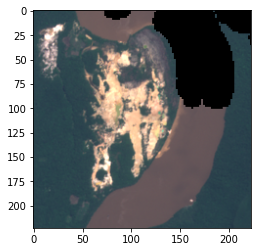

In [124]:
a = normalize(img_stack)
plt.imshow(np.squeeze(np.stack((a[:,:,:,3],
                    a[:,:,:,2],
                    a[:,:,:,1]), axis=-1)))

In [100]:
mining_sites['coords'].iloc[0]
5.653948145785468, -62.8905331998788

array([-63.58188048,   6.37298832])

{"features": [{"geometry": {"coordinates": [[[-63.57188, 6.371988], [-63.57188, 6.381988], [-63.58188, 6.381988], [-63.58188, 6.371988], [-63.57188, 6.371988]]], "type": "Polygon"}, "properties": {}, "type": "Feature"}], "type": "FeatureCollection"}

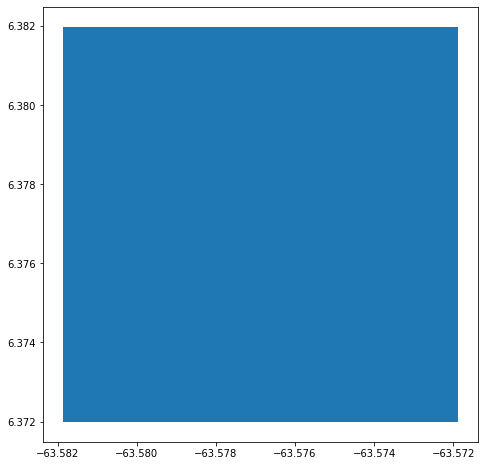

In [118]:
plot_sampling_grid([[-63.57688048,   6.37698832]], rect_width=0.01, output=True)

In [14]:
with open(os.path.join(data_dir, 'MinesNeg_caleb_selection.geojson'), 'r') as f:
    caleb_negatives = json.load(f)['features']

In [15]:
negative_river_sites = pd.DataFrame({
    'name': ['river_negative_' + str(i) for i in range(len(caleb_negatives))],
    'lon': [np.squeeze(site['geometry']['coordinates'])[0] for site in caleb_negatives],
    'lat': [np.squeeze(site['geometry']['coordinates'])[1] for site in caleb_negatives],
    'coords': [np.squeeze(site['geometry']['coordinates']) for site in caleb_negatives],
})
display(negative_river_sites.head())

,name,lon,lat,coords
0,river_negative_0,-61.996622,4.202724,"[-61.99662208557128, 4.202723853038541]"
1,river_negative_1,-61.980014,4.212290,"[-61.980013847351074, 4.212289581941978]"
2,river_negative_2,-61.960831,4.211819,"[-61.960830688476555, 4.211818788190996]"
3,river_negative_3,-61.965015,4.203216,"[-61.965014934539795, 4.203216052246488]"
4,river_negative_4,-61.957183,4.235529,"[-61.9571828842163, 4.235529318663943]"


In [16]:
# Positive site coordinates
positive_coords = list(mining_sites['coords'])
positive_names = list(mining_sites['name'])
print(len(positive_coords), 'positive sites loaded')

# Negative site coordinates
negative_coords = list(pd.concat([jungle_sites['coords'], negative_river_sites['coords']]))
negative_names = list(pd.concat([jungle_sites['name'], negative_river_sites['name']]))
print(len(negative_coords), 'negative sites loaded')

41 positive sites loaded
100 negative sites loaded


## Download Data

In [148]:
# Enter rect width in degrees (0.035 max recommended) and site coordinates
rect_width = 0.005
scale = 10
num_months = 4
start_date = '2019-05-01'

In [149]:
positive_history = get_history(positive_coords, 
                               positive_names, 
                               rect_width,
                               num_months = num_months,
                               start_date = start_date)

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [03:50<11:32, 230.80s/it]

 50%|█████     | 2/4 [08:19<08:04, 242.07s/it]

 75%|███████▌  | 3/4 [12:10<03:58, 238.97s/it]

100%|██████████| 4/4 [15:20<00:00, 230.09s/it]


In [ ]:
negative_history = get_history(negative_coords, 
                               negative_names, 
                               rect_width,
                               num_months = 2,
                               start_date = start_date)

In [ ]:
list(negative_history.keys())

In [ ]:
with open(os.path.join(data_dir, f'2d_mining_sites_{start_date}_{num_months}.pkl'), 'wb') as f:
    pickle.dump(positive_history, f)
    
with open(os.path.join(data_dir, f'2d_negative_sites_{start_date}_{num_months}.pkl'), 'wb') as f:
    pickle.dump(negative_history, f)

## Process Data for Network

In [578]:
with open(os.path.join(data_dir, '2d_mining_sites_2018-01-01_12.pkl'), 'rb') as f:
    positive_history = pickle.load(f)
    
with open(os.path.join(data_dir, '2d_negative_sites_2018-01-01_12.pkl'), 'rb') as f:
    negative_history = pickle.load(f)
    
with open('../data/84_px_bolivar_bootstrap_v1_negative.pkl', 'rb') as f:
    bolivar_bootstrap_negatives = pickle.load(f)
    
with open('../data/84_px_bolivar_bootstrap_v2_negative.pkl', 'rb') as f:
    bolivar_bootstrap_negatives_v2 = pickle.load(f)
    
with open('../data/84_px_bolivar_bootstrap_v2_positive.pkl', 'rb') as f:
    bolivar_bootstrap_positives_v2 = pickle.load(f)

with open('../data/caroni_positive_84px_5x_polygon_sampling.pkl', 'rb') as f:
    caroni_positive_sampling = pickle.load(f)
    
with open('../data/84_px_bolivar_inception_bootstrap_v3_positive.pkl', 'rb') as f:
    inception_positive = pickle.load(f)
    
with open('../data/84_px_bolivar_inception_bootstrap_v3_negative.pkl', 'rb') as f:
    inception_negative = pickle.load(f)

In [579]:
def create_img_stack(patch_history):
    img_stack = []
    for date in patch_history:
        for site in patch_history[date]:
            spectral_stack = []
            band_shapes = [np.shape(patch_history[date][site][band])[0] for band in band_descriptions]
            if np.array(band_shapes).all() > 0:
                for band in band_descriptions:
                    spectral_stack.append(patch_history[date][site][band])
                if np.median(spectral_stack) > 0:
                    img_stack.append(np.rollaxis(np.array(spectral_stack), 0, 3))
    return img_stack

def create_img_stack_mean(patch_history):
    mean_stack = []
    dates = list(patch_history.keys())
    for site in patch_history[dates[0]]:
        img_stack = []
        for date in dates:
            spectral_stack = []
            band_shapes = [np.shape(patch_history[date][site][band])[0] for band in band_descriptions]
            if np.array(band_shapes).all() > 0:
                for band in band_descriptions:
                    spectral_stack.append(patch_history[date][site][band])
                img_stack.append(np.rollaxis(np.array(spectral_stack), 0, 3))

        masked_img = []
        for img in img_stack:
            masked_img.append(np.ma.masked_where(img < 0, img))
        
        masked_mean = np.ma.mean(masked_img, axis=0)
        
        num_cloudy_pixels = np.sum(masked_mean.mask)
        cloud_fraction = num_cloudy_pixels / np.size(masked_mean)
        
        print("Cloud Fraction", cloud_fraction)
        if cloud_fraction < 0.2:
            mean_stack.append(masked_mean.data)
    return mean_stack


def normalize(x):
    return (np.array(x)) / (3000)

In [580]:
positive_img = create_img_stack_mean(positive_history)
print(len(positive_img), 'positive images extracted')

negative_img = create_img_stack_mean(negative_history)
print(len(negative_img), 'negative images extracted')

Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
41 positive images extracted
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 0.0
Cloud Fraction 1.0
Cl

In [170]:
subsampled_positives = []
for img in positive_img:
    for i in range(3):
        for j in range(3):
            subsampled_positives.append(img[i*28:(i+1)*28, 
                                            j*28:(j+1)*28, :])
subsampled_negatives = []
for img in negative_img:
    for i in range(3):
        for j in range(3):
            subsampled_negatives.append(img[i*28:(i+1)*28, 
                                            j*28:(j+1)*28, :])
positive_img = np.array(subsampled_positives)
negative_img = np.array(subsampled_negatives)

In [581]:
min_dimension = np.min([np.shape(img)[:2] for img in positive_img])
positive_img = [img[:min_dimension, :min_dimension, :] for img in positive_img]
negative_img = [img[:min_dimension, :min_dimension, :] for img in negative_img]

In [582]:
print(len(negative_img), len(bolivar_bootstrap_negatives), len(bolivar_bootstrap_negatives_v2))
print(len(positive_img), len(caroni_positive_sampling), len(bolivar_bootstrap_positives_v2))

94 288 159
41 190 133


In [583]:
negative_img = np.concatenate((negative_img, 
                               #bolivar_bootstrap_negatives, 
                               bolivar_bootstrap_negatives_v2,
                               inception_negative), axis=0)

positive_img = np.concatenate((positive_img, 
                               bolivar_bootstrap_positives_v2, 
                               caroni_positive_sampling, 
                               inception_positive), axis=0)

In [584]:
x = normalize(np.concatenate((positive_img, negative_img)))
y = np.concatenate((np.ones(len(positive_img)), np.zeros(len(negative_img))))
x, y = shuffle(x, y, random_state=42)

In [585]:
# Create Limited Band Dataset
#x_rgb = x[:,:,:,1:5]

In [586]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)
print("Num Train:\t\t", len(x_train))
print("Num Test:\t\t", len(x_test))
print(f"Percent Negative Train:\t {100 * sum(y_train == 0.0) / len(y_train):.1f}")
print(f"Percent Negative Test:\t {100 * sum(y_test == 0.0) / len(y_test):.1f}")

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Num Train:		 1107
Num Test:		 123
Percent Negative Train:	 47.1
Percent Negative Test:	 54.5


## Construct and Train Model

In [615]:
input_shape = np.shape(x_train[10])
print("Input Shape:", input_shape)

Input Shape: (84, 84, 12)


In [629]:
model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3), activation="relu"),
        layers.MaxPooling2D(pool_size=(3)),
        layers.Conv2D(32, kernel_size=(3), activation="relu"),
        layers.MaxPooling2D(pool_size=(3)),
        layers.Flatten(),
        layers.Dense(100, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(100, activation="relu"),
        #layers.Dropout(0.1),
        layers.Dense(100, activation="relu"),
        #layers.Dropout(0.1),
        layers.Dense(100, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(num_classes, activation="softmax")])
model.summary()

model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_176 (Conv2D)          (None, 82, 82, 16)        1744      
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 27, 27, 16)        0         
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_117 (MaxPoolin (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_53 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_248 (Dense)            (None, 100)               204900    
_________________________________________________________________
dropout_101 (Dropout)        (None, 100)             

In [589]:
#inception_model
input_layer = keras.Input(shape=x_train.shape[1:])

layer_1 = layers.Conv2D(8, kernel_size=(1), padding='same', activation='relu')(input_layer)
layer_1 = layers.Conv2D(8, kernel_size=(3), padding='same', activation='relu')(layer_1)
layer_1 = layers.MaxPooling2D(pool_size=(3), strides=(5), padding='same')(layer_1)

layer_2 = layers.Conv2D(8, kernel_size=(1), padding='same', activation='relu')(input_layer)
layer_2 = layers.Conv2D(8, kernel_size=(5), padding='same', activation='relu')(layer_2)
layer_2 = layers.MaxPooling2D(pool_size=(3), strides=(5), padding='same')(layer_2)

layer_3 = layers.MaxPooling2D(pool_size=(3), strides=(5), padding='same')(input_layer)
layer_3 = layers.Conv2D(8, kernel_size=(1), padding='same', activation='relu')(layer_3)

middle_1 = keras.layers.concatenate([layer_1, layer_2, layer_3], axis=3)

flat_1 = layers.Flatten()(middle_1)

dense_1 = layers.Dense(16, activation='relu')(flat_1)
dense_2 = layers.Dense(16, activation='relu')(dense_1)
dense_3 = layers.Dense(16, activation='relu')(dense_2)

output = layers.Dense(num_classes, activation="softmax")(dense_3)

inception_model = keras.Model([input_layer], output)

inception_model.summary()

inception_model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

Model: "functional_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 84, 84, 12)] 0                                            
__________________________________________________________________________________________________
conv2d_161 (Conv2D)             (None, 84, 84, 8)    104         input_53[0][0]                   
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, 84, 84, 8)    104         input_53[0][0]                   
__________________________________________________________________________________________________
conv2d_162 (Conv2D)             (None, 84, 84, 8)    584         conv2d_161[0][0]                 
______________________________________________________________________________________

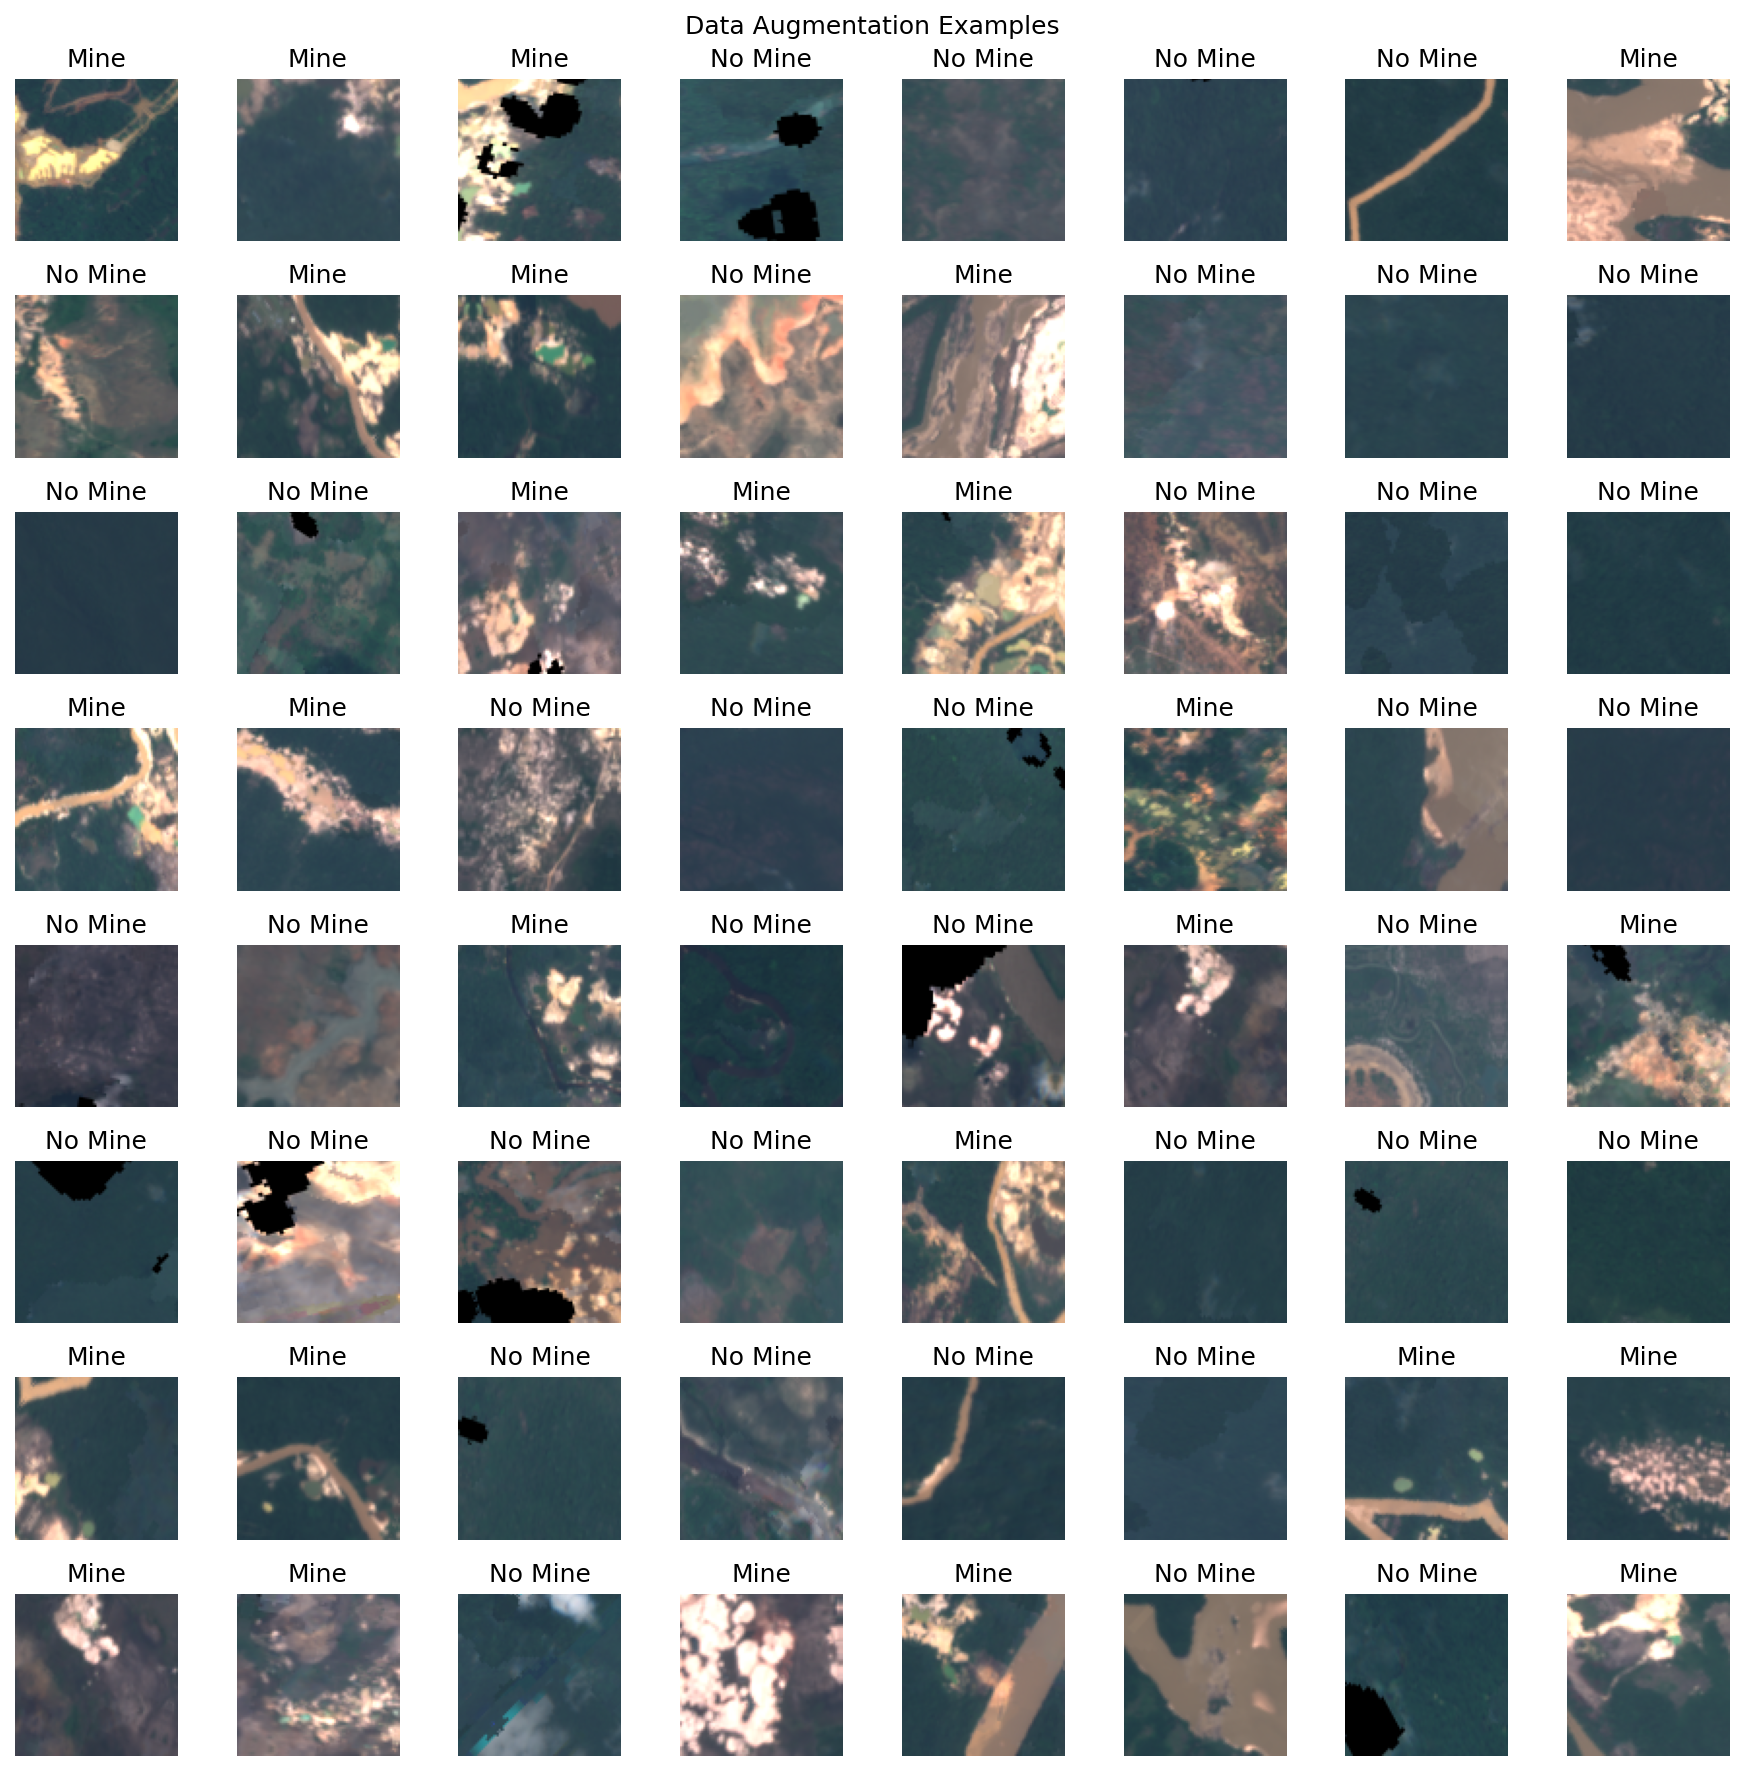

In [617]:
datagen = ImageDataGenerator(
    rotation_range=360,
    #brightness_range=[0.8,1.2],
    width_shift_range=[0.8, 1.2],
    height_shift_range=[0.8, 1.2],
    #shear_range=10,
    zoom_range=[0.8, 1.2],
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode='reflect'
)


plt.figure(figsize=(12,12), facecolor=(1,1,1), dpi=150)
images, labels = datagen.flow(x_train, y_train, batch_size=64).next()
for index, (image, label) in enumerate(zip(images, labels)):

    rgb = np.stack((image[:,:,3],
                    image[:,:,2], 
                    image[:,:,1]), axis=-1)
    plt.subplot(8, 8, index+1)
    plt.imshow(np.clip(rgb, 0, 1))
    if label[1] == 1:
        plt.title('Mine')
    else:
        plt.title('No Mine')
    plt.axis('off')
plt.suptitle('Data Augmentation Examples')
plt.tight_layout()
plt.show()
    

In [594]:
batch_size = 16
epochs = 50
inception_model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), 
          epochs=epochs, 
          validation_data = (x_test, y_test),
          verbose = 1
         )

Epoch 1/50
70/70 [==============================] - 12s 170ms/step - loss: 0.6719 - accuracy: 0.5537 - val_loss: 0.6547 - val_accuracy: 0.6667
Epoch 2/50
70/70 [==============================] - 12s 168ms/step - loss: 0.6075 - accuracy: 0.7525 - val_loss: 0.5956 - val_accuracy: 0.7805
Epoch 3/50
70/70 [==============================] - 10s 147ms/step - loss: 0.5571 - accuracy: 0.7859 - val_loss: 0.5459 - val_accuracy: 0.8130
Epoch 4/50
70/70 [==============================] - 12s 168ms/step - loss: 0.5150 - accuracy: 0.8076 - val_loss: 0.5002 - val_accuracy: 0.7724
Epoch 5/50
70/70 [==============================] - 10s 146ms/step - loss: 0.4799 - accuracy: 0.8275 - val_loss: 0.4633 - val_accuracy: 0.8049
Epoch 6/50
70/70 [==============================] - 12s 171ms/step - loss: 0.4542 - accuracy: 0.8275 - val_loss: 0.4288 - val_accuracy: 0.8374
Epoch 7/50
70/70 [==============================] - 12s 177ms/step - loss: 0.4255 - accuracy: 0.8546 - val_loss: 0.4380 - val_accuracy: 0.7886

In [630]:
batch_size = 32
epochs = 50
model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), 
          epochs=epochs, 
          validation_data = (x_test, y_test),
          verbose = 1
         )

Epoch 1/50
35/35 [==============================] - 7s 206ms/step - loss: 0.6516 - accuracy: 0.6079 - val_loss: 0.6036 - val_accuracy: 0.7398
Epoch 2/50
35/35 [==============================] - 7s 194ms/step - loss: 0.4990 - accuracy: 0.7787 - val_loss: 0.4438 - val_accuracy: 0.7805
Epoch 3/50
35/35 [==============================] - 7s 204ms/step - loss: 0.4078 - accuracy: 0.8311 - val_loss: 0.4588 - val_accuracy: 0.7805
Epoch 4/50
35/35 [==============================] - 7s 205ms/step - loss: 0.3841 - accuracy: 0.8275 - val_loss: 0.3653 - val_accuracy: 0.8130
Epoch 5/50
35/35 [==============================] - 7s 195ms/step - loss: 0.3489 - accuracy: 0.8573 - val_loss: 0.3293 - val_accuracy: 0.8537
Epoch 6/50
35/35 [==============================] - 7s 194ms/step - loss: 0.3258 - accuracy: 0.8609 - val_loss: 0.4386 - val_accuracy: 0.8130
Epoch 7/50
35/35 [==============================] - 7s 195ms/step - loss: 0.3426 - accuracy: 0.8564 - val_loss: 0.3126 - val_accuracy: 0.8780
Epoch 

0.03696058


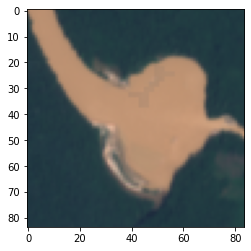

0.010115584


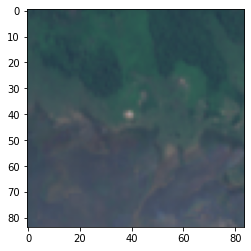

0.9869839


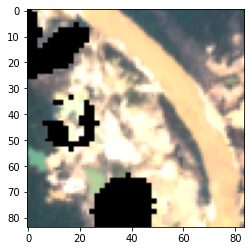

0.015302417


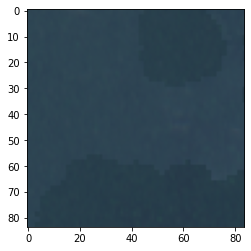

0.90487087


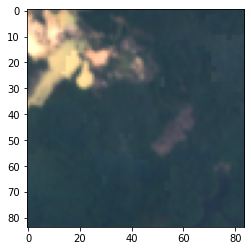

In [623]:
for index in range(5):
    pred = model.predict(np.expand_dims(x_test[0+index], axis=0))[0][1]
    print(pred)
    plt.imshow(np.clip(np.stack((x_test[index, :,:,3],
                        x_test[index, :,:,2],
                        x_test[index, :,:,1]), axis=-1), 0, 1))
    #print(np.min(x_test[index]), np.max(x_test[index]))
    plt.show()

In [613]:
model.save('../models/84_px_inception_v4_02-08-21.h5')

13 of 123 test set predictions incorrect
13 of 123 test set predictions incorrect
13 of 123 test set predictions incorrect
14 of 123 test set predictions incorrect
14 of 123 test set predictions incorrect
15 of 123 test set predictions incorrect
17 of 123 test set predictions incorrect
19 of 123 test set predictions incorrect
17 of 123 test set predictions incorrect
16 of 123 test set predictions incorrect
16 of 123 test set predictions incorrect
19 of 123 test set predictions incorrect
23 of 123 test set predictions incorrect
36 of 123 test set predictions incorrect


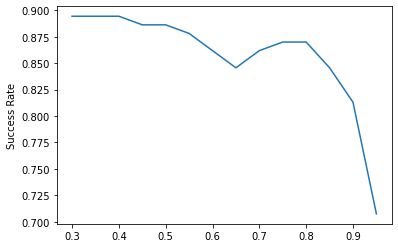

In [624]:
test_model = model
thresh = []
score = []
for threshold in range(30, 100, 5):
    threshold /= 100
    thresh.append(threshold)
    test_labels = [np.argmax(y) for y in y_test]
    test_preds = [pred > threshold for pred in test_model.predict(x_test)[:,1]]
    score.append(1 - np.sum(np.array(test_labels) != np.array(test_preds)) / len(test_labels))
    print(np.sum(np.array(test_labels) != np.array(test_preds)), "of", len(test_labels), "test set predictions incorrect")
plt.plot(thresh, score)
plt.ylabel('Success Rate')
plt.show()

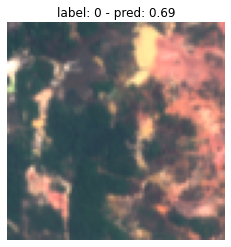

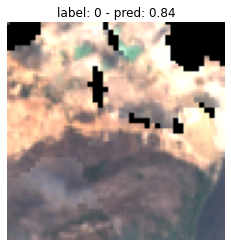

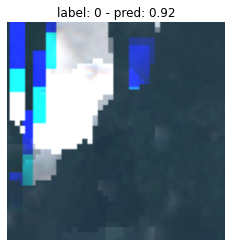

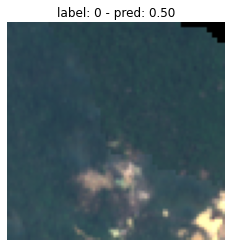

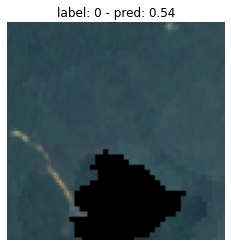

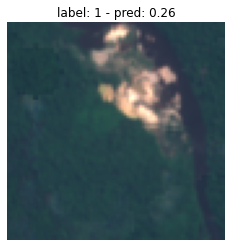

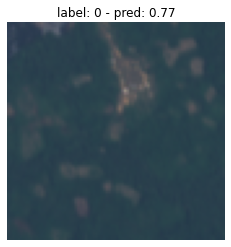

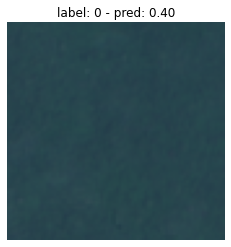

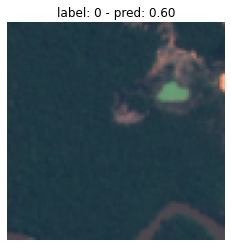

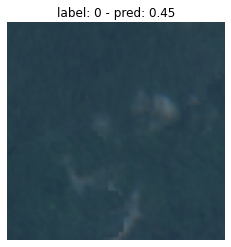

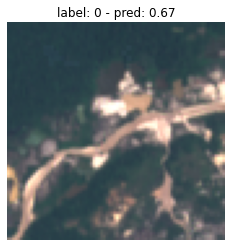

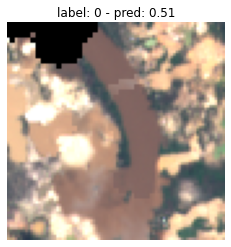

In [626]:
threshold = 0.4
test_labels = [np.argmax(y) for y in y_train]
test_preds = [pred > threshold for pred in test_model.predict(x_train)[:,1]]
for (label, pred, img) in zip(test_labels, test_model.predict(x_train)[:,1], x_test):
    if pred < threshold:
        binary_pred = 0
    else:
        binary_pred = 1
    if label != binary_pred:
        rgb = np.stack((img[:,:,3],
                      img[:,:,2],
                      img[:,:,1]), axis=-1)
        plt.imshow(np.clip(rgb, 0, 1))
        plt.title(f"label: {label} - pred: {pred:.2f}")
        plt.axis('off')
        plt.show()

# Evaluate Network on Grid

In [61]:
def create_img_stack(patch_history):
    img_stack = []
    for date in patch_history:
        for site in patch_history[date]:
            spectral_stack = []
            band_shapes = [np.shape(patch_history[date][site][band])[0] for band in band_descriptions]
            if np.array(band_shapes).all() > 0:
                for band in band_descriptions:
                    spectral_stack.append(patch_history[date][site][band])
                if np.median(spectral_stack) > 0:
                    img_stack.append(np.rollaxis(np.array(spectral_stack), 0, 3))
    return img_stack

def normalize(x):
    return (np.array(x)) / (3000)

def create_sampling_grid(min_lon, max_lon, min_lat, max_lat, steps_lon, steps_lat):
    lons = np.linspace(min_lon, max_lon, steps_lon)
    lats = np.linspace(min_lat, max_lat, steps_lat)
    lon, lat = np.meshgrid(lons, lats)
    coords = [[lon, lat] for lon, lat in zip(lon.flatten(), lat.flatten())]
    return coords

def plot_sampling_grid(coords, rect_width=0.025, output=False):
    sampling_df = pd.DataFrame({
        'lon': [coord[0] for coord in coords],
        'lat': [coord[1] for coord in coords],
        'pred': [0 for _ in range(len(coords))]
    })
    
    features = []
    for lon, lat in zip([coord[0] for coord in coords], [coord[1] for coord in coords]):
        rect = box(lon - rect_width / 2, lat - rect_width / 2, lon + rect_width / 2, lat + rect_width / 2)
        features.append(Feature(geometry=rect))
    feature_collection = FeatureCollection(features)
    geopandas.GeoDataFrame.from_features(feature_collection).plot(figsize=(10, 8))
    
    if output:
        return feature_collection
    

def get_image_stack(coords, start_date='2020-05-01', rect_width=0.025, scale=100):
    names = ['sample_' + str(i) for i in range(len(coords))]
    history = get_history(coords, 
                          names,
                          rect_width,
                          start_date=start_date,
                          num_months=1,
                          #scale=rect_width * (100 / 0.025)
                          scale=scale
                         )
    img_stack = create_img_stack(history)
    print("Image shape before cropping:", img_stack[0].shape)
    min_dim = np.min(img_stack[0].shape[:2])
    img_stack = [img[:min_dim, :min_dim, :] for img in img_stack]
    
    return history, img_stack

def predict_grid(model, history, img_stack, coords):
    
    preds = model.predict(normalize(img_stack))[:,1]
    
    cloud_free_coords = []
    for site, coords in zip(history[start_date], coords):
        if np.median(history[start_date][site]['B2']) > 0:
            cloud_free_coords.append(coords)

    preds_df = pd.DataFrame({
        'pred': preds,
        'lon': [coord[0] for coord in cloud_free_coords],
        'lat': [coord[1] for coord in cloud_free_coords]}
    )

    return preds_df
    
def write_data(data_frame, file_path, rect_width):
    data_frame.to_csv(file_path + '.csv', index=False)
    
    features = []
    for lon, lat, pred in zip(list(data_frame['lon']), list(data_frame['lat']), list(data_frame['pred'])):
        rect = box(lon - rect_width / 2, lat - rect_width / 2, lon + rect_width / 2, lat + rect_width / 2)
        features.append(Feature(geometry=rect, properties={'pred': pred}))

    feature_collection = FeatureCollection(features)
    with open(file_path + '.geojson', 'w') as f:
       dump(feature_collection, f)
    
    geopandas.GeoDataFrame.from_features(feature_collection).plot(column='pred', 
                                                                  cmap='seismic',
                                                                  figsize=(10, 8),
                                                                  vmin=0,
                                                                  vmax=1)

    
def stretch_histogram(array, min_val=0.1, max_val=0.75, gamma=1.2):
    clipped = np.clip(array, min_val, max_val)
    stretched = np.clip((clipped - min_val) / (max_val - min_val) ** gamma, 0, 1)
    return stretched

In [ ]:
rect_width = 0.02

#tambopata whole
min_lon, max_lon = -70.72, -69.8
min_lat, max_lat = -13.2, -12.57

# Caroni whole
#min_lon, max_lon = -63.09674922312161, -62.18700279001181
#min_lat, max_lat = 4.514923184841662, 6.511625537541098

#min_lon, max_lon = -70.64, -70.4
#min_lat, max_lat = -12.96, -13.07


steps_lon = 20
steps_lat = 15

sampling_coords = create_sampling_grid(min_lon, max_lon, min_lat, max_lat, steps_lon, steps_lat)
plot_sampling_grid(sampling_coords, rect_width)


In [ ]:
start_date='2019-05-01'
scale = 20
history, img_stack = get_image_stack(sampling_coords, start_date=start_date, rect_width=rect_width, scale=scale)

file_path = f"../data/tambopata_mine_{min_lon},{max_lon}_{min_lat},{max_lat}_{rect_width}_{scale}"
with open(file_path + '.pkl', 'wb') as f:
    pickle.dump(img_stack, f)

preds_df = predict_grid(model, history, img_stack, sampling_coords)
write_data(preds_df, file_path, rect_width)



In [ ]:
start_date='2019-09-01'
scale = 20
history, img_stack = get_image_stack(positive_coords, start_date=start_date, rect_width=rect_width, scale=scale)
file_path = f"../data/positive_sites_{rect_width}_{scale}"
with open(file_path + '.pkl', 'wb') as f:
    pickle.dump(img_stack, f)


In [ ]:
start_date='2019-09-01'
scale = 20
history, img_stack = get_image_stack(negative_coords, start_date=start_date, rect_width=rect_width, scale=scale)

file_path = f"../data/negative_sites_{rect_width}_{scale}"
with open(file_path + '.pkl', 'wb') as f:
    pickle.dump(img_stack, f)

In [ ]:
plt.imshow(img_stack[0][:,:,3])

In [ ]:
num_img = int(np.ceil(np.sqrt(len(img_stack))))

plt.figure(figsize=(36,36), dpi=150)
for index, (img, pred) in enumerate(zip(img_stack, preds_df['pred'])):
    plt.subplot(num_img, num_img, index + 1)
    plt.imshow(stretch_histogram(normalize(np.stack((img[:,:,3],
                         img[:,:,2],
                         img[:,:,1]), axis=-1
                        ))))
    plt.title(f"{pred:.0%}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
len(preds)

## Test the network on candidate site

In [ ]:
num_months = 6
test_coords = [-62.42462292953776, 4.870750832241027]
#test_coords = [-62.39958492247051, 4.848350836417974]
#test_coords = [-61.73903184056069, 4.3381195947723405]
#test_coords = [-61.74202162706261, 4.417347798525773]
test_patch = get_history([test_coords], 
                           ['test_patch'],
                           rect_width,
                           start_date=start_date,
                           num_months=num_months)

test_data = create_img_stack(test_patch)
test_data = [img[:84, :84, :] for img in test_data]

In [ ]:
num_img = int(np.ceil(np.sqrt(len(test_data))))
preds = []
plt.figure(figsize=(8,8), facecolor=(1,1,1))
for index, month in enumerate(test_data):
    im = np.expand_dims(normalize(month), 0)
    rgb = np.stack((normalize(month[:,:,3]),
                    normalize(month[:,:,2]), 
                    normalize(month[:,:,1])), axis=-1)
    pred = model.predict(im)[0][1]
    preds.append(pred)
    plt.subplot(num_img, num_img, index + 1)
    plt.imshow(np.clip(rgb, 0, 1), vmin=0, vmax=1)
    plt.title(f"{100 * pred:.0f}%")
    plt.axis('off')
plt.suptitle(f"Mean Classification: {100*np.mean(preds):.0f}%\nSite: {test_coords[1]:.3f}°, {test_coords[0]:.3f}°", size=16)
plt.tight_layout()
#plt.savefig(f'/Users/ckruse/Downloads/{test_coords[1]:32f}, {test_coords[0]:.3f}.png', bbox_inches='tight')
plt.show()

## Test network on river sampling sites

In [ ]:
data_dir = os.path.join('..', '..', 'mining', 'data')

with open(os.path.join(data_dir, 'test_sampling_sites.geojson'), 'r') as f:
    test_sites = json.load(f)['features']

In [ ]:
test_sites = pd.DataFrame({
    'name': ['test_' + str(i) for i in range(len(test_sites[0]['geometry']['coordinates']))],
    'lon': [coords[0] for coords in test_sites[0]['geometry']['coordinates']],
    'lat': [coords[0] for coords in test_sites[0]['geometry']['coordinates']],
    'coords': [coords[:2] for coords in test_sites[0]['geometry']['coordinates']],
})
display(test_sites.head())

In [ ]:
offset = 0.005
sampling_coords = []
sampling_names = []
for coord, name in zip(test_sites['coords'], test_sites['name']):
    sampling_coords.append(coord)
    sampling_coords.append([coord[0] - offset, coord[1] - offset])
    sampling_coords.append([coord[0] + offset, coord[1] + offset])
    
    sampling_names.append(name)
    sampling_names.append(name + '_right')
    sampling_names.append(name + '_left')

plt.figure(figsize=(12,12))
plt.scatter([coord[0] for coord in sampling_coords], [coord[1] for coord in sampling_coords], s=1)
plt.show()

In [ ]:
pd.DataFrame([coord[0] for coord in sampling_coords], [coord[1] for coord in sampling_coords])
a = pd.DataFrame()
a['lat'] = [coord[1] for coord in sampling_coords]
a['lon'] = [coord[0] for coord in sampling_coords]
a.to_csv('/Users/ckruse/Downloads/river_sampling.csv')

In [ ]:
river_sampling = get_history(sampling_coords, 
                         sampling_names,
                         0.0025,
                         start_date=start_date,
                         num_months=1)

In [ ]:
river_sampling[start_date]['test_0']['B2'].shape

In [ ]:
river_patches = get_history(test_sites['coords'], 
                         test_sites['name'],
                         rect_width,
                         start_date=start_date,
                         num_months=1)

In [ ]:
river_data = create_img_stack(river_patches)

In [ ]:
river_sampling_data = create_img_stack(river_sampling)
river_sampling_data = [img[:28, :28, :] for img in river_sampling_data]

In [ ]:
river_data = [img[:min_dimension, :min_dimension, :] for img in river_data]

In [ ]:
np.shape(river_sampling_data)

In [ ]:
subsampled_river = []
subsampled_coords = []
for img, coords in zip(river_sampling_data, sampling_coords):
    for i in range(2):
        for j in range(2):
            subsampled_lon = coords[0] + rect_width * ((0.5 * j) - 1)
            subsampled_lat = coords[1] - rect_width * ((0.5 * i) - 1)
            subsampled_coords.append([subsampled_lon, subsampled_lat])
            subsampled_river.append(img[i*28:(i+1)*28, j*28:(j+1)*28, :])

In [ ]:
np.shape(subsampled_river[0])

In [ ]:
for site in river_sampling[start_date]:
    if np.min(river_sampling[start_date][site]['B2']) < 0:
          print(site)

In [ ]:
print(np.where(np.array(sampling_names) == 'test_54_right'))
print(np.where(np.array(sampling_names) == 'test_55_right'))

In [ ]:
np.array(sampling_names).shape

In [ ]:
sampling_coords[163]

In [ ]:
np.concatenate((sampling_coords[:163], sampling_coords[164:166], sampling_coords[167:]))

In [ ]:
preds = model.predict(normalize(river_sampling_data))[:,1]

In [ ]:
len(preds)

In [ ]:
predictions = pd.DataFrame(preds, columns=['pred'])
predictions['lat'] = [coord[1] for coord in np.concatenate((sampling_coords[:163], sampling_coords[164:166], sampling_coords[167:]))]
predictions['lon'] = [coord[0] for coord in np.concatenate((sampling_coords[:163], sampling_coords[164:166], sampling_coords[167:]))]
predictions.head()
predictions.to_csv('/Users/ckruse/Downloads/subsampled_mine_preds_2.csv')

In [ ]:
# Plot blob locations on a satellite base image
from keplergl import KeplerGl
river_map = KeplerGl(data={'samples': predictions})

In [ ]:
num_samples = 20 ** 2
num_img = int(np.ceil(np.sqrt(len(river_sampling_data[:num_samples]))))
preds = []
plt.figure(figsize=(24,24), facecolor=(1,1,1))
for index, site in enumerate(river_sampling_data[:num_samples]):
    im = np.expand_dims(normalize(site), 0)
    rgb = np.stack((normalize(site[:,:,3]),
                    normalize(site[:,:,2]), 
                    normalize(site[:,:,1])), axis=-1)
    pred = model.predict(im)[0][1]
    preds.append(pred)
    plt.subplot(num_img, num_img, index + 1)
    plt.imshow(np.clip(rgb, 0, 1), vmin=0, vmax=1)
    plt.title(f"{100 * pred:.0f}%")
    plt.axis('off')
plt.tight_layout()
#plt.savefig(f'/Users/ckruse/Downloads/{test_coords[1]:32f}, {test_coords[0]:.3f}.png', bbox_inches='tight')
plt.show()

# Tambopata Test

In [ ]:
# Create a grid of coordinates:
min_lon, max_lon = (-70.72, -69.8)
min_lat, max_lat = (-13.07, -12.73)

num_samples = 30

lons = np.linspace(min_lon, max_lon, num_samples)
lats = np.linspace(min_lat, max_lat, num_samples)
lon, lat = np.meshgrid(lons, lats)
peru_coords = [[lon, lat] for lon, lat in zip(lon.flatten(), lat.flatten())]
peru_names = ['tambopata_' + str(i) for i in range(len(peru_coords))]

In [ ]:
start_date = '2020-05-01'
tambopata = get_history(peru_coords, 
                        peru_names,
                        0.0025,
                        start_date=start_date,
                        num_months=1)

In [ ]:
tambopata_stack = create_img_stack(tambopata)
tambopata_stack = [img[:28, :28, :] for img in tambopata_stack]

In [ ]:
preds = model.predict(normalize(tambopata_stack))[:,1]

In [ ]:
cloud_free_coords = []
for site, coords in zip(tambopata[start_date], peru_coords):
    if np.min(tambopata[start_date][site]['B2']) > 0:
        cloud_free_coords.append(coords)

In [ ]:
peru_preds = pd.DataFrame(preds, columns=['pred'])
peru_preds['lat'] = [coord[1] for coord in cloud_free_coords]
peru_preds['lon'] = [coord[0] for coord in cloud_free_coords]

peru_preds.to_csv('/Users/ckruse/Downloads/tambopata_preds.csv')
peru_preds.head()

In [ ]:
preds_df

In [ ]:
rect_width = 0.025
min_lon, max_lon = -70.72, -69.8
min_lat, max_lat = -13.2, -12.57
num_samples = 20
sampling_grid = create_sampling_grid(min_lon, max_lon, min_lat, max_lat, num_samples, num_samples)
sampling_df = pd.DataFrame({
    'lon': [coord[0] for coord in sampling_grid],
    'lat': [coord[1] for coord in sampling_grid],
    'pred': [0 for _ in range(len(sampling_grid))]
})

write_data(sampling_df, f'/Users/ckruse/Downloads/grid_{min_lon},{max_lon}_{min_lat},{max_lat}_{rect_width}', rect_width)

In [ ]:

tambopata_train_df, tambopata_train_img = predict_grid(min_lon, max_lon, min_lat, max_lat, num_samples, num_samples, rect_width=rect_width)
write_data(tambopata_train_df, f'/Users/ckruse/Downloads/tambopata_{min_lon},{max_lon}_{min_lat},{max_lat}_{rect_width}', rect_width)

In [ ]:
peru_south_wide = predict_grid(-70.72, -68.88, -13.41, -13.07, 60, 30)
peru_south_wide.head()

In [ ]:
pd.concat([peru_preds, peru_preds_north, peru_east, peru_south, peru_south_wide]).to_csv(os.path.join(data_dir, 'tambopata_grid_full.csv'), index=False)

In [ ]:
# Create a grid of coordinates:
min_lon, max_lon = (-70.72, -69.8)
min_lat, max_lat = (-13.07, -12.73)

num_samples = 30

lons = np.linspace(min_lon, max_lon, num_samples)
lats = np.linspace(min_lat, max_lat, num_samples)
lon, lat = np.meshgrid(lons, lats)
peru_coords = [[lon, lat] for lon, lat in zip(lon.flatten(), lat.flatten())]
peru_names = ['tambopata_' + str(i) for i in range(len(coords))]

In [ ]:
start_date = '2020-05-01'
tambopata_north = get_history(peru_coords, 
                        peru_names,
                        0.0025,
                        start_date=start_date,
                        num_months=1)

In [ ]:
tambopata_stack_north = create_img_stack(tambopata_north)
tambopata_stack_north = [img[:28, :28, :] for img in tambopata_stack_north]

In [ ]:
np.shape(tambopata_stack_north)

In [ ]:
preds_north = model.predict(normalize(tambopata_stack_north))[:,1]

In [ ]:
cloud_free_coords_north = []
for site, coords in zip(tambopata_north[start_date], peru_coords):
    if np.min(tambopata_north[start_date][site]['B2']) > 0:
        cloud_free_coords_north.append(coords)

In [ ]:
peru_preds_north = pd.DataFrame(preds_north, columns=['pred'])
peru_preds_north['lat'] = [coord[1] for coord in cloud_free_coords_north]
peru_preds_north['lon'] = [coord[0] for coord in cloud_free_coords_north]

peru_preds_north.to_csv('/Users/ckruse/Downloads/tambopata_preds_north.csv')
peru_preds_north.head()

In [ ]:
pd.concat([peru_preds, peru_preds_north, peru_east, peru_south]).to_csv(os.path.join(data_dir, 'tambopata_grid.csv'), index=False)

## River Head

In [ ]:
tambopata_train_df

In [ ]:
river_head.to_csv('/Users/ckruse/Downloads/river_head.csv', index=False)

In [ ]:
tambopata_train_df, tambopata_train_img = predict_grid(-70.6, -70.3, -13.01, -12.95, 1, 1)

In [ ]:
write_data(tambopata_train_df, '/Users/ckruse/Downloads/test_bigger')